_Neural Data Science_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2022

Student name: Yirong Xiong & Hanru Zhang

# Coding Lab 3

Not every cluster in the fitted mixture model corresponds to a single neuron’s spikes (i.e. is a ‘single unit’). We will explore different ways of identifying single units and telling them apart from multi unit activity. In all your plots, color-code the clusters consistently. 

If needed, download the data file ```nda_ex_2_*.npy``` from ILIAS and save it in the subfolder ```../data/```. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from sklearn.decomposition import PCA
from scipy.io import loadmat
import copy

sns.set_style('whitegrid')
%matplotlib inline

## Load data

In [2]:
m = np.load('../data/nda_ex_2_meansnpy.sec')
S = np.load('../data/nda_ex_2_covsnpy.sec')
a = np.load('../data/nda_ex_2_labelsnpy.sec')
p = np.load('../data/nda_ex_2_pisnpy.sec')

b = np.load('../data/nda_ex_1_featuresnpy.sec')
t = np.load('../data/nda_ex_1_spiketimes_tnpy.sec')
s = np.load('../data/nda_ex_1_spiketimes_snpy.sec')
w = np.load('../data/nda_ex_1_waveformsnpy.sec')



## Task 1: Visual inspection of clusters

The most obvious candidates for single units are clusters that you can identify visually as being well separated from the rest. You can use the plotting function you implemented last week (Exercise 2 Task 4) as a first tool to identify putative single units. Of course there may be other less obvious cases in the data.

*Grading: 0 pts*


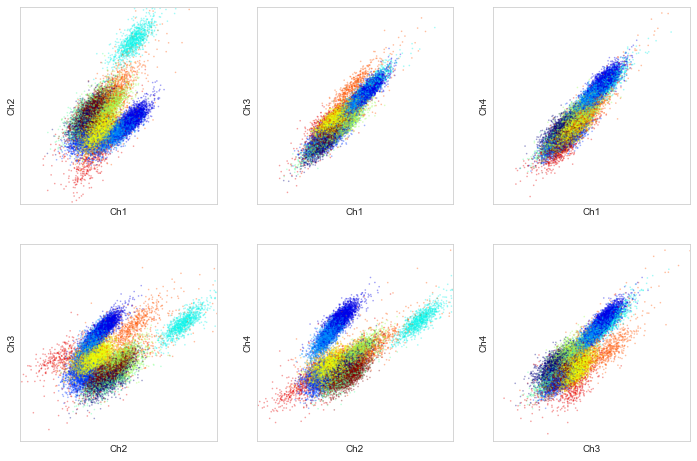

In [3]:
colors = plt.cm.jet(np.linspace(0,1,max(a)+1))

fig = plt.figure(figsize=(12, 8))


# insert your code here

n_feature = 3

p=1

labels = ['Ch1','Ch2','Ch3','Ch4']
for i in np.arange(0,4):
    for j in np.arange(i+1,4):
        ax = plt.subplot(2,3, p, aspect='equal')
        plt.scatter(b[:,n_feature*i],b[:,n_feature*j],s=.5,c=colors[a,:],alpha=.3) 
        plt.xlabel(labels[i])
        plt.ylabel(labels[j])
        plt.xlim((-900,1200))
        plt.ylim((-900,1200))
        ax.set_xticks([])
        ax.set_yticks([])
        p+=1


plt.show()

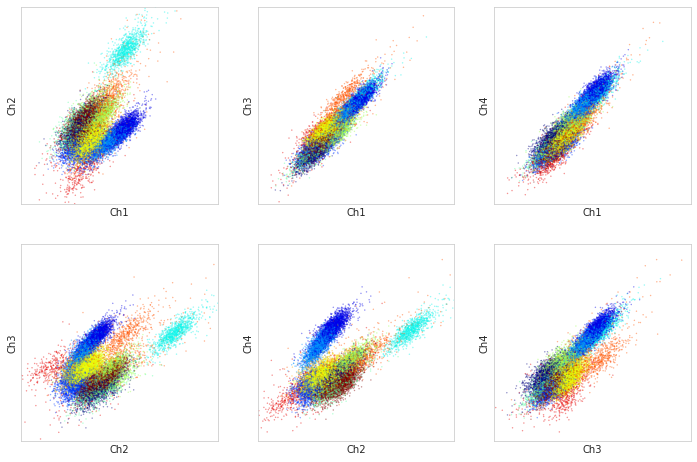

## Task 2: Visual inspection of waveforms

Plot the average waveforms and 100 examples from each cluster. This is a good sanity check and helps to identify potential artifacts such as electrical noise or clusters representing overlapping spikes (they often have large variance and few spikes). 

*Grading: 2 pts*


In [4]:
def plot_waveforms(w, labels, N=100):
    
    '''Plot waveforms for all four channels of each cluster.
    Plot 100 sample waveforms, overlaid by the average.
    All panels are drawn on the same scale to facilitate comparison.
    
    Parameters
    ----------
    
    w: np.array, (len_waveform, n_samples, n_channels)
        Waveform.
        
    labels: np.array, (n_samples, )
        Cluster label for each datapoint.
        
    N: int, default = 100
        Number of waveforms to be plotted per cluster.
        
    '''
    # Insert your code here
    len_waveform, n_channels = w.shape[0],w.shape[2]

    # -------------------------------------------------------------------
    # Plot 100 examples and the average waveform for each cluster (2 pts)
    # -------------------------------------------------------------------

    colors = plt.cm.Paired(np.linspace(0,1,max(labels)+1))
    fig,axs = plt.subplots(4,12,figsize=(15, 5),sharex=True, sharey=True)
    for i in range(n_channels):
        for j,label in enumerate(np.unique(labels)):
            
            wvform = w[:,np.where(labels==label)[0],i]
            if wvform.shape[1]<N:
                axs[i,j].plot(range(len_waveform),wvform,c='black',alpha=.3) 
            else:
                axs[i,j].plot(range(len_waveform),wvform[:,np.random.randint(low = 0, high=wvform.shape[1], size=N)],c='gray',alpha=.8) 
            axs[i,j].plot(range(len_waveform),np.average(wvform,axis=1),c=colors[label]) 
            axs[i,j].set_ylim((-500,300))
            if j==0:
                axs[i,j].set_yticks([-200,0,200])
#             else:
#                 axs[i,j].set_yticks([])
            if i==n_channels-1:
                axs[i,j].set_xticks([0,10,20,30])
#             else:
#                 axs[i,j].set_xticks([])
    fig.text(0.5, 0, 'time bins', ha='center')
    fig.text(0, 0.5, 'voltage', va='center', rotation='vertical')
            
    plt.tight_layout()
                
                
            

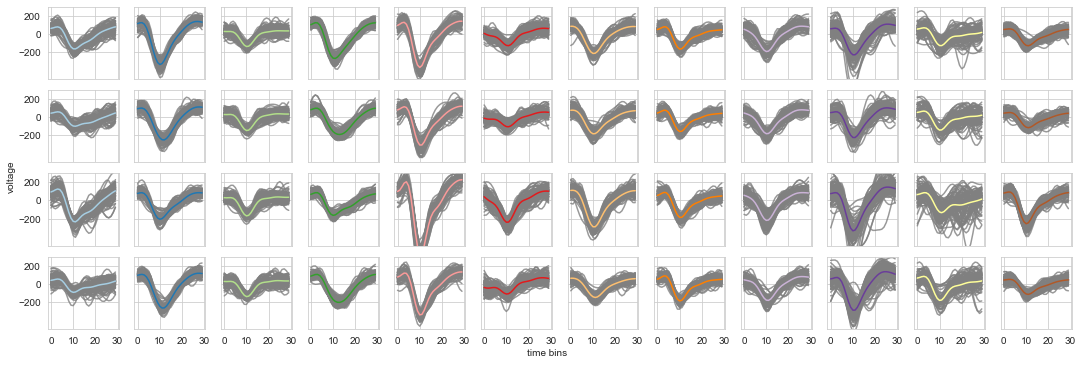

In [67]:
plot_waveforms(w, a)

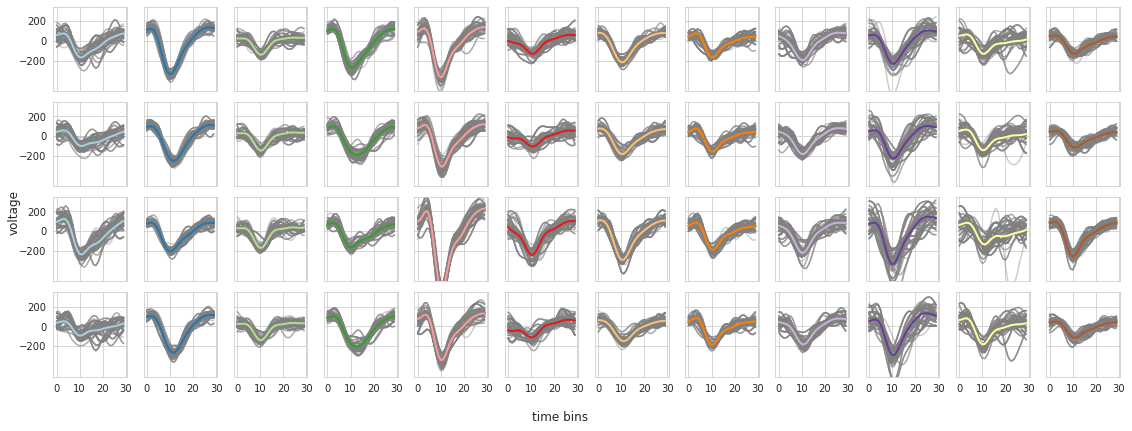

## Task 3: Auto/cross-correlation
Implement a function to calculate the auto/cross-correlograms of all clusters/pairs of clusters called `correlogram()`. Correlograms are useful mostly for two reasons:

* To identify clusters that represent multi unit activity. Neurons have a refractory period: after firing a spike they cannot fire another spike within a period of time (at least 1 ms, often more, depending on the cell type). Thus, if multiple cells contribute to one cluster, it won’t have a refractory period. 
* To identify two (or more) clusters that represent the same single unit: if this is the case the cross-correlogram of the two clusters should show the refractory period, since it consists of spikes from only one cell, which cannot occur too close to each other. 

Plot a matrix with cross- and auto-correlograms like shown in the lecture. Use a bin size of 0.5 ms and a range of ±20 ms. Which auto-correlograms show a refractory period? Which cross-correlograms do?   

You need to take some care to ensure that the implementation of the crosscorrelogram function is efficient, otherwise this may take a while.


*Grading: 4 pts*



In [6]:
def hist_target(tar,binsize,maxlag,spike):
    tar_window = np.where(abs(tar-spike)<maxlag)[0]
    return np.bincount(((tar[tar_window]-spike+maxlag)/binsize).astype(int), minlength=int(np.floor(2*maxlag/binsize)))

In [7]:
def correlogram(t, labels, binsize, maxlag):

    '''Calculate cross correlogram. 
    
    Parameters
    ----------
    
    t: np.array, shape=(n_spikes, )
        Spike times.
        
    labels: np.array, shape=(n_spikes, )
        Cluster labels for each spike
    
    binsize: float
        Bin size.
        
    maxlag: int
        Maximal lag.
        
    
    Returns
    -------
    
    ccg: np.array, shape=(n_bins, n_clusters, n_clusters)
        computed correlograms
    
    bins: np.array, shape=(n_bins, )
        time bins relative to center 
    '''
    
    # insert your code here
    n_bins = int(np.floor(2*maxlag/binsize))
    n_clusters = len(np.unique(labels))
    
    ccg = np.empty((n_bins,n_clusters,n_clusters))
    
    for i,ref in enumerate(np.unique(labels)):
        for j,tar in enumerate(np.unique(labels)[i:]):
            
            t_tar = t[np.where(labels==tar)[0]]
            t_ref = t[np.where(labels==ref)[0]]
            
            hist_li = [hist_target(t_tar,binsize,maxlag,spike) for spike in t_ref]
            ccg[:,ref,tar] = np.sum(np.vstack(hist_li),axis=0)
            
            if ref!=tar:
                ccg[:,tar,ref] = ccg[:,ref,tar][::-1]
            else:
                ccg[int(n_bins/2),ref,tar] = ccg[int(n_bins/2),ref,tar] - len(t_ref)
    # -------------------------------------------------
    # compute correlogram in a given timewindow (3 pts)
    # -------------------------------------------------
    
    bins = np.arange(-maxlag+binsize/2, maxlag+binsize/2, binsize)
    
    return ccg, bins

In [8]:
def plot_ccg(ccg, bins, figsize=(18, 18)):

    '''Plot cross correlogram matrix. 
    
    Parameters
    ----------
    
    ccg: np.array, shape=(n_bins, n_clusters, n_clusters)
        computed correlograms
    
    bins: np.array, shape=(n_bins, )
        time bins relative to center

    figsize: Tuple
        Set size of figure
    '''

    # insert your code here
    # ---------------------------
    # Plot crosscorelogram (1 pt)
    # ---------------------------
    n_bins,n_clusters,=ccg.shape[0:2]
    colors = plt.cm.Paired(np.linspace(0,1,n_clusters))
    fig,axs = plt.subplots(n_clusters,n_clusters,figsize=figsize, sharex=True)
    
    for i in range(n_clusters):
        for j in range(n_clusters):
            if i==j:
                color = colors[i]
            else:
                color = 'black'
            axs[i,j].bar(x=bins,height=ccg[:,i,j],facecolor=color, edgecolor=color)

            axs[i,j].set_yticks([])
            
    fig.text(0.5, 0, 'delays (ms)', ha='center')
    fig.text(0, 0.5, 'correlation', va='center', rotation='vertical')
            
    plt.tight_layout()

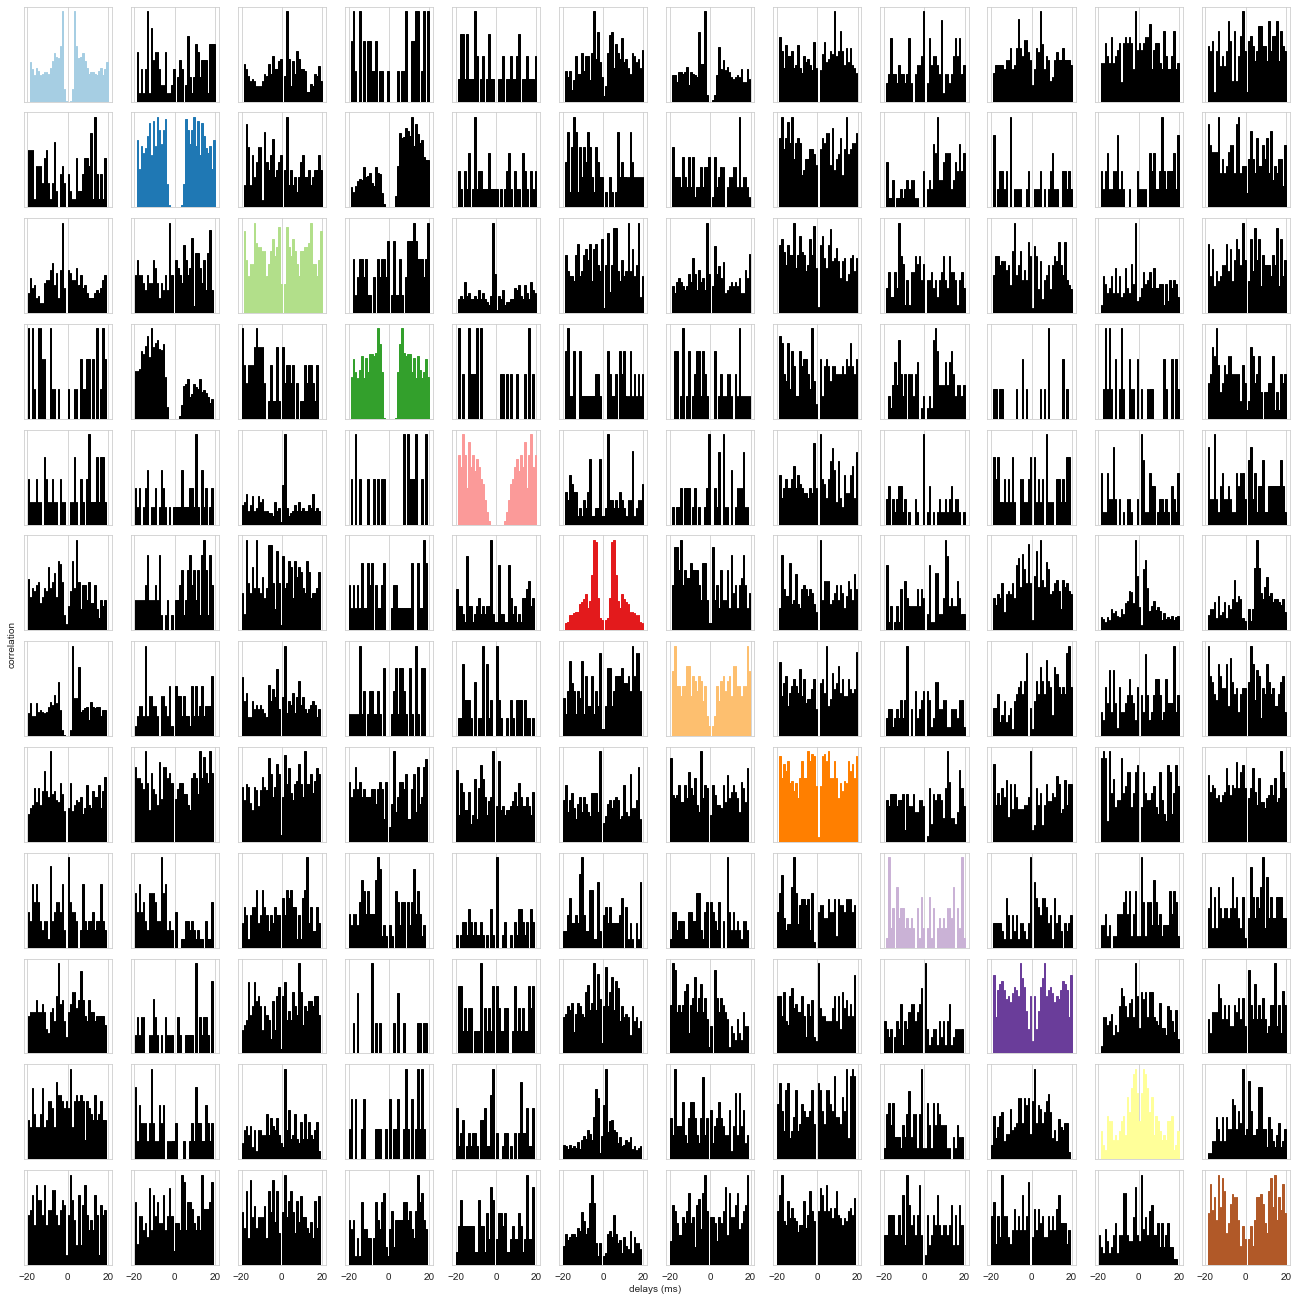

In [9]:
ccg, bins = correlogram(t, a, 1, 20)
plot_ccg(ccg, bins)

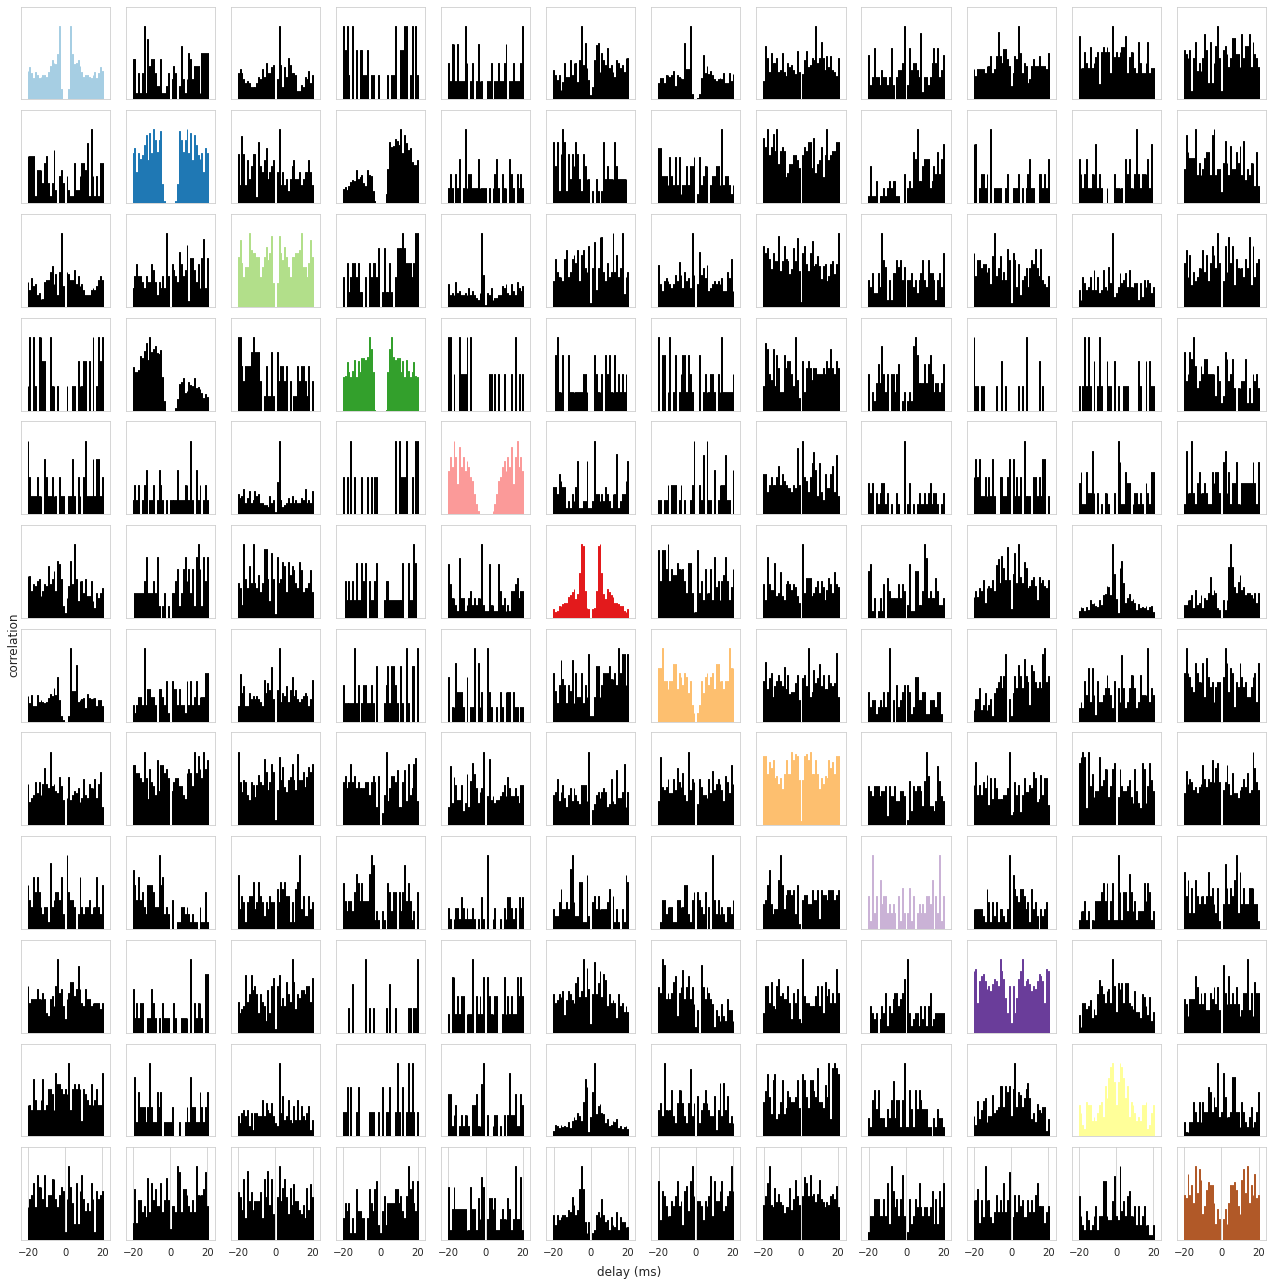

### Task 4: Cluster separation
Implement linear discriminant analysis to visualize how well each cluster is separated from its neighbors in the high-dimensional space in the function `separation()`. Project the spikes of each pair of clusters onto the axis that optimally separates those two clusters. 

Plot a matrix with pairwise separation plots, showing the histogram of the points in both clusters projected on the axis best separating the clusters (as shown in the lecture). *Hint:* Since Python 3.5+, matrix multiplications can be compactely written as `x@y`.


*Grading: 4 pts*


In [65]:
def separation(b, m, S, p, assignment, nbins=50, figure=3):
    
    '''Calculate cluster separation by LDA.
    
    proj, bins = separation(b, m, S, p, assignment) 
    projects the data on the LDA axis for all pairs of clusters. The result
    is normalized such that the left (i.e. first) cluster has 
    zero mean and unit variances. The LDA axis is estimated from the model.
    ---
       
    Parameters
    ----------
    b: np.array, (n_spikes, n_features)
        Features.
    
    m: np.array, (n_clusters, n_features)
        Means.
        
    S: np.array, (n_features, n_features, n_clusters)
        Covariance.
        
    p: np.array, (n_clusters, )
        Cluster weight.
    
    assignment: np.array, (n_spikes, )
        Cluster assignments / labels for each spike

    
    Returns
    -------
    
    proj: np.array, (n_bins, n_clusters, n_clusters)
        computed lda histo# Comparing the cells in particular
# Each row of pixels in one of the subplots represents on row/column in the cluster seperation plot above
# the colour codes for the height of the bar plots
compare_cell_pair(proj, [1,3], "Comparing Cell 1 and 3")
compare_cell_pair(proj, [5,6], "Comparing Cell 5 and 6")
compare_cell_pair(proj, [9,10], "Comparing Cell 9 and 10")grams   #bins x #clusters x #clusters
        
    bins: np.array, (n_bins)
        bin times relative to center    #bins x 1
    '''

    # insert your code here
    n_spikes, n_features = b.shape
    n_clusters = m.shape[0]
    colors = plt.cm.jet(np.linspace(0, .9, n_clusters))
    proj = np.zeros((nbins-1, n_clusters, n_clusters))
    bins = np.linspace(-3, 10, nbins)
    fig,axs = plt.subplots(n_clusters, n_clusters, figsize=(12,12), sharex=True)
    # ---------------------------------------------------------------------
    # compute the optimal separating axes for each pair of clusters (2 pts)
    # ---------------------------------------------------------------------
    for i in range(n_clusters):
        for j in range(n_clusters):
            if i!=j:
                w = (np.linalg.inv(S[:,:,i]+S[:,:,j]))@(m[i,:] - m[j,:])
                pi = b[assignment==i,:]@w
                pj = b[assignment==j,:]@w

    # -------------------------------------------
    # normalise according to first cluster (1 pt)
    # -------------------------------------------
    
                mean,std = np.average(pj),np.std(pj,ddof=1)
                pi = np.histogram((pi - mean)/std, bins=bins)[0]
                pj = np.histogram((pj - mean)/std, bins=bins)[0]
                
                proj[:,i,j] = np.histogram(np.concatenate((pi,pj),axis=0), bins=bins)[0]
    # --------------------------------------
    # plot histograms on optimal axis (1 pt)
    # --------------------------------------
                axs[j,i].set_facecolor((0.7,0.7,0.7))
                
                axs[j,i].bar(x=bins[1:],height=pi,facecolor=colors[i,:],edgecolor=colors[i,:])
                axs[j,i].bar(x=bins[1:],height=pj,facecolor=colors[j,:],edgecolor=colors[j,:])
                
                axs[j,i].set_ylim([0, 1.2*np.max(pj)])
                axs[j,i].set_xlim([-3, 10])
            axs[j,i].set_yticks([])
            axs[j,i].set_xticks([])
            
    return proj, bins

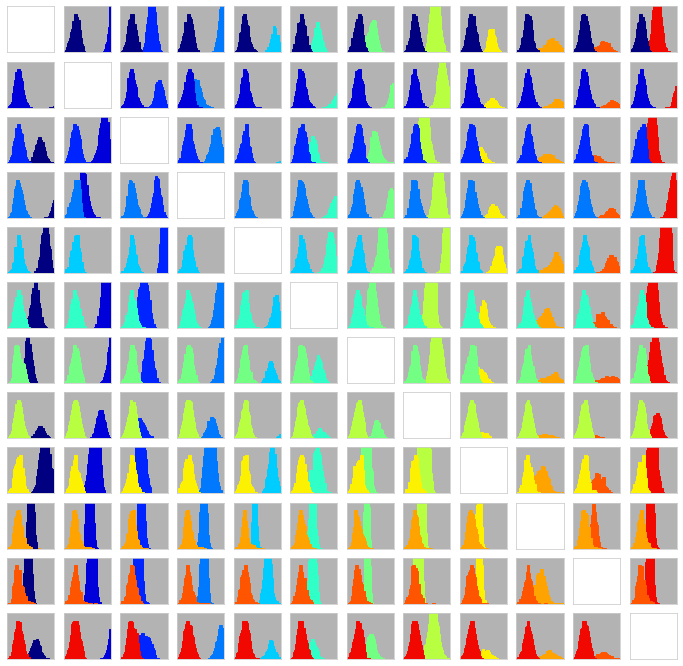

In [66]:
proj, bins = separation(b,m,S,p,a)

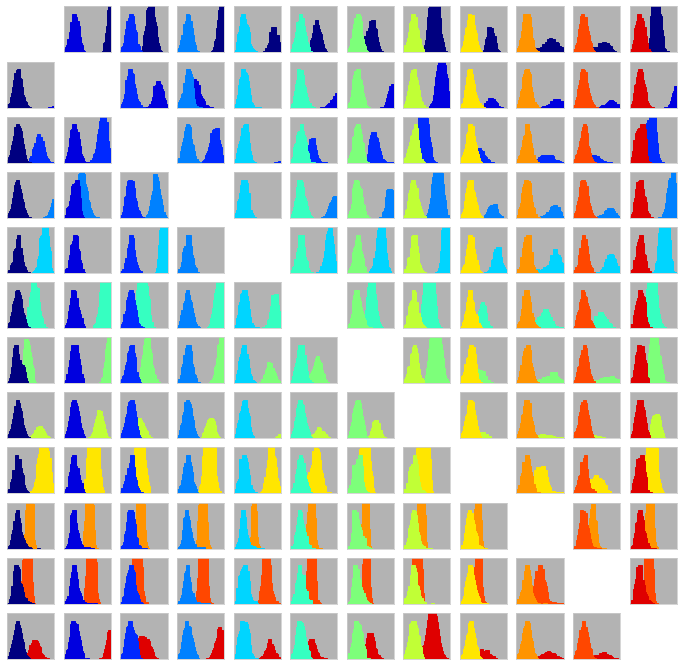

## Task 5: Identify putative single units. 

Use all of the above tools to identify all putative single units in the dataset. Which ones are these and why?

### PCA 
- light blue cluster is a single unit, we can see clearly from channel 2
- blue and purple clusters are separated from the other clusters, but they two are totally mixed -> probably it's one unit. 

### Waveform
- 2,4,5 clusters have obvious spike shape and low variance across times, probably each of them is from single unit.  
- 10,11 have spike shape but huge variance, which means a lot of noise. 

### correlogram
- cross-correlogram between cluster 7 and 1 shows refractory period, might including single unit activity. 
- cluster 1, 2, 4, 5 have refractory period. but the rest of auto-correlogram showed noisy signal. 

The cross-correlogram indicate that cluster 1,3 and 4 describe single unit activity. However, the correlogram also reveals that cluster 1 and cluster 3 probably record the same cell since there is a refactory period visible in their cross-correlogram.
Thus, we can identify the single units [1,3] and 4.

In [ ]:
# insert your code here